# **Redes Convolucionais para Classificação de Imagens do Dataset MSCOCO**

#### **Professores:** Roberto A. Lotufo e Rodrigo F. Nogueira
#### **Aluno:** Guilherme Rosa

### **1. Imports**

In [ ]:
import h5py
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter, OrderedDict

In [ ]:
!nvidia-smi

Sun Oct  4 19:20:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

Usando: cuda


### **2. Preparação dos dados**

#### **2.1. Download das amostras de treinameto, valdidação e teste**

In [ ]:
# Download do dataset

#### **2.2. Implementação da subclasse da classe Dataset**


In [ ]:
class MSCOCODataset(Dataset):
    def __init__(self, images_hdf5_path, captions_json_path, wordmap_json_path, transforms=None):
        """ Cria uma instância da classe torch.utils.data.Dataset customizada para o dataset de imagens do MSCOCO.
            É utilizada pelo torch.utils.data.DataLoader como base para criar os mini-batches de treinamento.  
        """
        super(MSCOCODataset, self).__init__()

        self.images_hdf5_path = images_hdf5_path
        self.captions_json_path = captions_json_path
        self.wordmap_json_path = wordmap_json_path
        self.transforms = transforms

        self.images = self.__getimages()
        self.labels = self.__getlabels()
        self.wordmap = json.load(open(self.wordmap_json_path, 'r'))
        self.wordmap_reverse = {labels: classes for classes, labels in self.wordmap.items()}

    def __len__(self):
        """ Retorna o número de amostras do dataset. """
        return self.images.shape[0]
    
    def __getitem__(self, index):
        """ Permite que a classe possa ser indexada. Retorna uma tupla com o par de tensores (imagem, label) referente ao índice dado. """

        images = self.images[index]
        images = self.__standartization(images)  # Normalização entre 0 e 1 para cada canal da imagem de entrada:
        images = torch.tensor(images, dtype=torch.float)

        if self.transforms:
            images = self.transforms(images)
        
        # É feita uma modificação nas labels para que as classes sejam representadas por variáveis categóricas de 0 a 9, e não de 1 a 10 como está originalmente no dataset.
        # O tipo dos dados foi modificado para torch.uint8 para reduzir o uso de memória.
        labels = torch.tensor(self.labels[index]-1, dtype=torch.long)
        return images, labels
    
    def __getimages(self):
        """ Faz a leitura do arquivo HDF5 com o módulo h5py e retorna o dataset contendo as imagens. """

        images_hdf5file = h5py.File(self.images_hdf5_path, mode='r')
        return images_hdf5file['images']
    
    def __getlabels(self):
        """ Faz a leitura do arquivo json com o módulo json e retorna as labels para cada imagem."""

        captions_jsonfile = json.load(open(self.captions_json_path, 'r'))
        labels = np.array(captions_jsonfile[::5])    # Como existem 5 captions por imagem, a mesma label é repetida 5x. Por essa razão pegamos as labels com passo de 5.
        labels = labels[::, 1]    # Ao verificar o conteúdo de cada lista, vemos que as labels estão armazenadas na segunda posição (índice 1).
        return labels

    def plot_sample_data(self):
        """ Apresenta 10 amostras do conjunto de dados. """

        fig = plt.figure(figsize=(20, 10))
        for i, idx in enumerate(torch.randint(0, self.images.shape[0], size=(10,))):
            fig.add_subplot(2, 5, i+1)
            plt.imshow(np.transpose(self.images[idx], (1, 2, 0)))
            plt.title(f'Classe: {self.wordmap_reverse[self.labels[idx]]}')
            plt.xticks([])
            plt.yticks([])
        del i, idx        
    
    def dataset_info(self):
        """ Apresenta o número de amostras por classe do conjunto de dados. """
        
        self.classes_name = [self.wordmap_reverse[label] for label in self.labels]
        self.num_elements = Counter(self.classes_name)
        for class_name, num_elements in self.num_elements.items():
            print(f'{class_name.title()}: {num_elements}')
        del self.classes_name, class_name, num_elements
    
    def __standartization(self, image):
        """ Normaliza os pixels de cada canal da imagem de modo que fiquem dentro do intervalo [0, 1]. """

        image = (image - np.min(image, axis=(2,1), keepdims=True))/(np.max(image, axis=(2,1), keepdims=True) - np.min(image, axis=(2,1), keepdims=True))
        return image

In [ ]:
train_dataset = MSCOCODataset('/content/TRAIN_IMAGES_coco_5_cap_per_img_5_min_word_freq.hdf5', 
                             '/content/TRAIN_CAPTIONS_coco_5_cap_per_img_5_min_word_freq.json',
                              '/content/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json')

valid_dataset = MSCOCODataset('/content/VAL_IMAGES_coco_5_cap_per_img_5_min_word_freq.hdf5', 
                             '/content/VAL_CAPTIONS_coco_5_cap_per_img_5_min_word_freq.json',
                              '/content/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json')

test_dataset = MSCOCODataset('/content/TEST_IMAGES_coco_5_cap_per_img_5_min_word_freq.hdf5', 
                             '/content/TEST_CAPTIONS_coco_5_cap_per_img_5_min_word_freq.json',
                             '/content/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json')

In [ ]:
print('Número de amostras do conjunto de treinamento:')
train_dataset.dataset_info()
print()
print('Número de amostras do conjunto de validação:')
valid_dataset.dataset_info()
print()
print('Número de amostras do conjunto de teste:')
test_dataset.dataset_info()

Número de amostras do conjunto de treinamento:
Cat: 3124
Truck: 1518
Boat: 1452
Bird: 1043
House: 1243
Car: 2093
Airplane: 2168
Horse: 1890
Tree: 2626
Dog: 3660

Número de amostras do conjunto de validação:
Cat: 162
Car: 109
Airplane: 75
Truck: 62
Tree: 120
Horse: 96
Dog: 161
House: 53
Bird: 43
Boat: 62

Número de amostras do conjunto de teste:
Airplane: 87
Truck: 80
Dog: 152
House: 65
Boat: 73
Tree: 105
Bird: 47
Cat: 147
Horse: 78
Car: 98


#### **2.3. Exemplos de amostras do dataset MSCOCO**

Exemplos de amostras de treinamento:

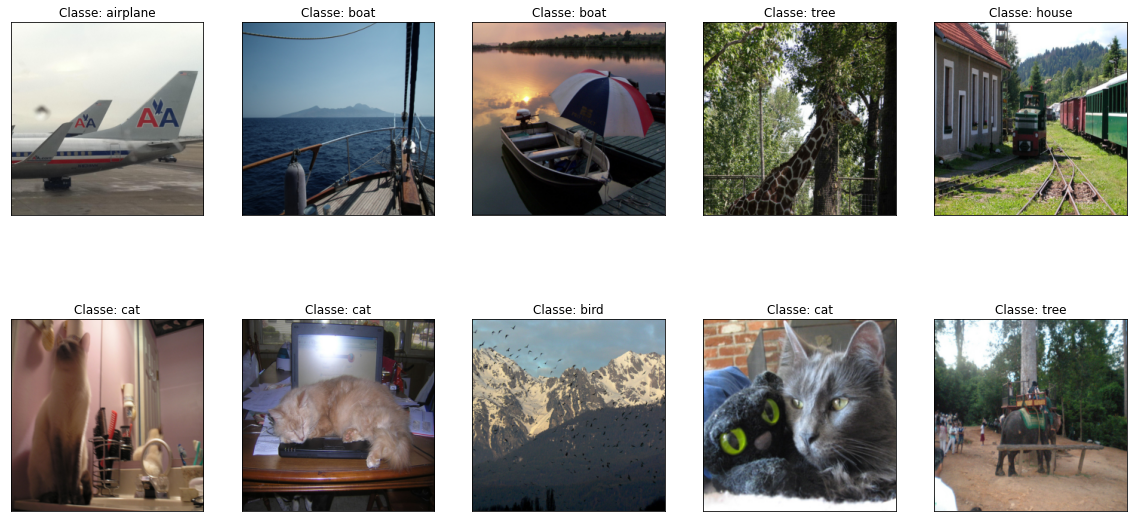

In [ ]:
train_dataset.plot_sample_data()

Exemplos de amostras de validação:

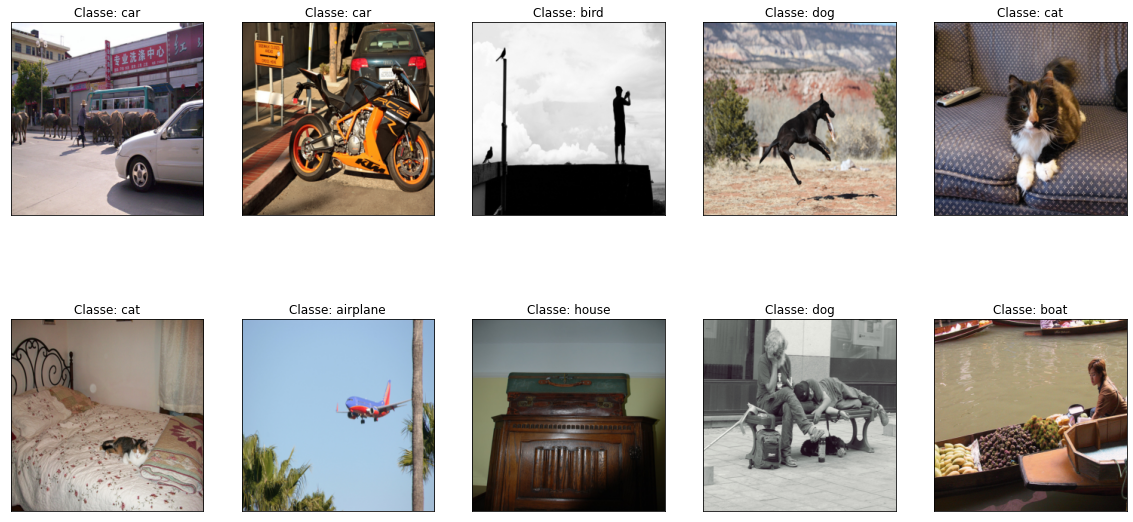

In [ ]:
valid_dataset.plot_sample_data()

Exemplos de amostras de teste:

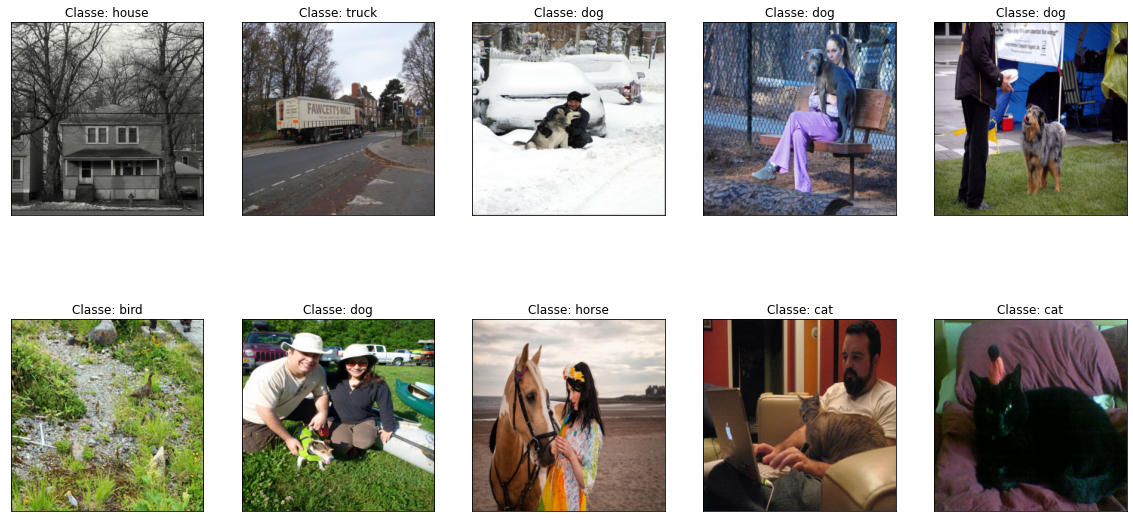

In [ ]:
test_dataset.plot_sample_data()

### **3. Funções auxiliares**

#### **3.1. Função para cálculo da acurácia (taxa de acerto):**

In [ ]:
def accuracy_metric(logits, labels):
    probs = F.softmax(logits, dim=1)                         # Retorna as probabilidades de saída para cada amostra do mini-batch
    top_prob, top_class = probs.topk(1, dim=1)               # Método topk() retorna o(s) k maior(es) valor(es) e seu(s) índice(s)
    equals = top_class == labels.view(*top_class.shape)      # Retorna tensor booleano com True para as amostras classificadas corretamente.
    batch_score = torch.sum(equals.type(torch.FloatTensor))  # Soma o número de acertos no mini-batch
    
    return batch_score

#### **3.2. Função para plotar os gráficos do custo e da acurácia:**

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, num):
    plt.figure(num)
    plt.plot(train_metric, label='Training '+ metric_name)
    plt.plot(val_metric, label='Validation ' + metric_name)
    plt.title(metric_name.title() + ' vs Epochs')
    plt.legend(frameon=False)

    return

#### **3.3. Função de treinamento:**

- O decorador @torch.enable_grad() permite que o gradiente seja calculado para os parâmetros do modelo.

- O método model.train() é necessário para ativar o Dropout durante o treinamento, isto é, que a cada mini-batch apresentado um conjunto aleatório de neurônios seja desligado.

In [ ]:
@torch.enable_grad()
def train(dataloader, model, criterion, optimizer, device):
    running_loss = 0          # Acumula o custo dos mini-batches ao longo da época
    running_score = 0         # Acumula o número de acertos do modelo

    model.train()
    for images, labels in dataloader:

        logits = model(images.to(device))             # Etapa forward
        loss = criterion(logits, labels.to(device))   # Cálculo da função custo
        running_loss += loss.item()                   # Custo acumulado
        optimizer.zero_grad()               
        loss.backward()                               # Etapa backward (cálculo do gradiente)
        optimizer.step()                              # Ajuste dos pesos sinápticos do modelo
        running_score += accuracy_metric(logits.cpu(), labels.cpu()) # Cálculo da acurácia 
    
    epoch_loss = running_loss/len(dataloader)         # Custo médio da época
    epoch_score = 100*running_score/(len(dataloader)*dataloader.batch_size)  # Taxa de acerto da época
                                     
    print('Training loss: {:.4f}'.format(epoch_loss), end=' -- ')
    print('Training accuracy: {:.2f}%'.format(epoch_score), end=' -- ')

    return epoch_loss, epoch_score

#### **3.4. Função de validação (evaluate):**

- O decorador @torch.no_grad() não calcula o gradiente na validação do modelo, pois durante esta etapa nenhum ajuste é feito. Com isso, há uma redução do tempo e da memória, já que naõ serão construídos grafos.

- O método model.eval() faz com que o dropout fique desativado. Isso significa que todos os neurônios do modelo estão ativados, com pesos sinápticos dados pelo produto dos pesos da última iteração de treinamento pela probabilidade dos neurônios estarem ativados.

In [ ]:
@torch.no_grad()
def evaluate(dataloader, model, criterion, device):
    running_loss = 0
    running_score = 0
    
    model.eval()
    for images, labels in dataloader:
        logits = model(images.to(device))             # Etapa forward
        loss = criterion(logits, labels.to(device))   # Cálculo da função custo
        running_loss += loss.item()                   # Custo acumulado
        running_score += accuracy_metric(logits.cpu(), labels.cpu()) # Cálculo da acurácia

    epoch_loss = running_loss/len(dataloader)
    epoch_score = 100*running_score/(len(dataloader)*dataloader.batch_size)
                                     
    print('Validation loss: {:.4f}'.format(epoch_loss), end=' -- ')
    print('Validation accuracy: {:.2f}%'.format(epoch_score))
    
    return epoch_loss, epoch_score

#### **3.5. Função de teste (predict):**

- O decorador @torch.no_grad() não calcula o gradiente na validação do modelo, pois durante esta etapa nenhum ajuste é feito. Com isso, há uma redução do tempo e da memória, já que naõ serão construídos grafos.

- O método model.eval() faz com que o dropout fique desativado. Isso significa que todos os neurônios do modelo estão ativados, com pesos sinápticos dados pelo produto dos pesos da última iteração de treinamento pela probabilidade dos neurônios estarem ativados.

In [ ]:
@torch.no_grad()
def predict(dataloader, model, criterion, device):
    running_loss = 0
    running_score = 0
    
    model.eval()
    for images, labels in dataloader:
        logits = model(images.to(device))             # Etapa forward
        loss = criterion(logits, labels.to(device))   # Cálculo da função custo
        running_loss += loss.item()                   # Custo acumulado
        running_score += accuracy_metric(logits.cpu(), labels.cpu()) # Cálculo da acurácia

    epoch_loss = running_loss/len(dataloader)
    epoch_score = 100*running_score/(len(dataloader)*dataloader.batch_size)
                                     
    print('Test loss: {:.4f}'.format(epoch_loss), end=' -- ')
    print('Test accuracy: {:.2f}%'.format(epoch_score))
    
    return epoch_loss, epoch_score

#### **3.6. Função main**

In [ ]:
def main(trainloader, validloader, model, criterion, optimizer, device, epoch):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for e in range(epoch):
        print(f'Epoch: {e + 1}/{epoch}')
        train_loss, train_acc = train(trainloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(validloader, model, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    plot_metrics(train_losses, val_losses, 'loss', 1)
    plot_metrics(train_accs, val_accs, 'accuracy', 2)

    return

### **4. Parâmetros da classe Conv2d do PyTorch**

Referência: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

A classe Conv2d do PyTorch apresenta os seguintes parâmetros:

- **in_channels**: número de canais da imagem de entrada.
  - Se a imagem de entrada estiver na escala RGB, por exemplo, o número de canais é igual a 3.
  - Se a imagem de entrada estiver na escala cinza de cores, o número de canais é igual a 1.
  - Se a imagem de entra for a saída de uma camada convolucional, o número de canais é igual ao número de *kernels* da camada anterior.

- **out_channels**: número de canais da imagem de saída. 
  - Esse valor também se refere ao número de *kernels* que processam em paralelo a imagem de entrada.

- **kernel_size**: a dimensão dos *kernels* convolutivos (largura e altura). 
  - A profundidade dos *kernels* é igual a *in_channels*.
  - Costuma-se utilizar *kernels* "quadrados", isto é, com largura igual a altura.

- **stride**: é o passo de deslocamento dos *kernels* durante a operação de convolução. 
  - Costuma-se aplicar o mesmo valor de passo tanto no deslocamento horizontal quanto no vertical.

- **padding**: nome dado ao processo de preenchimento dos canais de entrada com pixels nulos. O parâmetro *padding* define a largura do preenchimento.
  - O *padding* permite que os pixels das bordas da imagem de entrada possam ser centralizados no centro dos *kernels* e, assim, diminuir a perda de informação desses pixels.
  - Dependendo dos valores do *padding* e do *stride*, a imagem de saída pode ter dimensão igual ou maior que a da imagem de entrada. 

- **dilation**: é um processo de sub-amostragem em que os pesos dos *kernels* não ponderam pixels vizinhos da imagem de entrada em um único produto escalar, mas sim pixels intercalados. O parâmetro *dilation* define quantos pixels estão entre dois pixels que serão ponderados pelos pesos dos *kernels*. 

- **bias**: define se o parâmetro *bias* é criado para o *kernel*. *Default*: *True*.

- **padding_mode**: forma de preenchimento que será realizado. *Default*: *zeros*.

- **groups**: controla o número de conexões entra os canais de entrada e de saída.
  - Se *groups = 1*: a profundidade dos *kernels* é igual ao número de canais da imagem de entrada, e cada canal da imagem de saída é dada pela convolução entre um *kernel* e todos os canais da imagem de entrada (é a convolução usual).
  - Se *groups = 2*: a profundidade dos *kernels* é igual à metade do número de canais da imagem de entrada. É como se houvesse 2 camadas convolucionais lado-a-lado.
    - Metade dos *kernels* realizam a convolução com a primeira metade dos canais de entrada, produzindo metade dos canais de saída.
    - A outra metade dos *kernels* realizam a convolução com a segunda metade dos canais de entrada, produzindo a segunda metade dos canais de saída.
  - *groups = in_channels*: a profundidade dos *kernels* é igual a 1. Cada canal de saída é dado pela convolução entre um *kernel* e um canal de entrada.
  - Explicação didática: https://blog.yani.io/filter-group-tutorial/


### **5. Rede convolucional I**

#### **5.1. Definição do modelo**


In [ ]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()

        self.feature_extraction = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)),
            ('relu1', nn.ReLU()),
            ('maxpool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
            ('relu2', nn.ReLU(0.5)),
            ('maxpool2', nn.MaxPool2d(kernel_size=2)),
            ('dropout2', nn.Dropout(0.5)),
            ('conv3', nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)),
            ('relu3', nn.ReLU(0.5)),
            ('maxpool3', nn.MaxPool2d(kernel_size=2)),
            ('dropout3', nn.Dropout(0.5))            
        ]))

        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(in_features=30*30*32, out_features=256)),
            ('relu4', nn.ReLU(0.5)),
            ('dropout4', nn.Dropout(0.5)),
            ('output', nn.Linear(in_features=256, out_features=10)),
        ]))


    def forward(self, x):
        x = self.feature_extraction(x)
        x = x.view(x.shape[0], -1)
        x = self.classification(x)
        return x

#### **5.2. Cálculo do número de parâmetros**

Em camadas *fully-connected*, o cálculo do número de parâmetros é dado por:

$$
n_{param} = n_{features} \times n_{neurons} + n_{neurons}
$$

o termo que contém a multiplicação se refere aos pesos sinápticos, enquanto que o termo adicionado à este se refere aos bias. Logo, cada neurônio possui $n_{features}$ pesos sinápticos e $1$ bias.

Em camadas convolucionais, o cálculo do número de parâmetros é dado por:

$$
n_{param} = n_{kernels} \times w_{kernel} \times h_{kernel} \times n_{input-channels} + n_{kernels}
$$

em que $w_{kernel}$ e $h_{kernel}$ são, respectivamente, a largura e altura de um kernel da camada, $n_{input-channels}$ é o número de canais da imagem de entrada e $n_{kernels}$ é o número de kernels da camada.

O termo que contém as multiplicações se refere aos pesos sinápticos, enquanto que o termo adicionado à este se refere aos bias. Logo, cada *kernel* possui $w_{kernel} \times h_{kernel} \times n_{input-channels}$ pesos sinápticos e $1$ bias.

**Cálculo manual**:

In [ ]:
# Camada convolucional 1:
n_param_convlayer1 = 64*3*3*3 + 64 
# Camada convolucional 2:
n_param_convlayer2 = 64*3*3*64 + 64
# Camada convolucional 3:
n_param_convlayer3 = 32*3*3*64 + 32
# Camada linear 1:
n_param_linear = (30*30*32)*256 + 256
# Camada de saída:
n_param_output = 256*10 + 10

hands = [n_param_convlayer1, n_param_convlayer2, n_param_convlayer3, n_param_linear, n_param_output]
hands.append(np.sum(np.array(hands)))

for i, params in enumerate(hands):
    if i < len(hands)-2:
        print(f'Camada intermediária {i+1}: {params}')
    elif i == len(hands)-2:
        print(f'Camada de saída: {params}')
    else:
        print(f'Modelo completo: {params}')

Camada intermediária 1: 1792
Camada intermediária 2: 36928
Camada intermediária 3: 18464
Camada intermediária 4: 7373056
Camada de saída: 2570
Modelo completo: 7432810


**Cálculo a partir do modelo**

In [ ]:
convnet = ConvNet1()
num_params = [params.numel() for params in list(convnet.parameters())] # Lista com o número de parâmetros de cada camada com bias e weights passados separadamente
num_params = list(np.array(num_params[::2]) + np.array(num_params[1::2])) # Lista com o número de parâmetros totais por camada
num_params.append(np.sum(np.array(num_params))) # Último elemento da lista tem o número total de parâmetros do modelo

for i, params in enumerate(num_params):
    if i < len(num_params)-2:
        print(f'Camada intermediária {i+1}: {params}')
    elif i == len(num_params)-2:
        print(f'Camada de saída: {params}')
    else:
        print(f'Modelo completo: {params}')

del convnet

Camada intermediária 1: 1792
Camada intermediária 2: 36928
Camada intermediária 3: 18464
Camada intermediária 4: 7373056
Camada de saída: 2570
Modelo completo: 7432810


#### **5.3. Treinamento**

Epoch: 1/10
Training loss: 2.0538 -- Training accuracy: 26.27% -- Validation loss: 1.8964 -- Validation accuracy: 30.31%
Epoch: 2/10
Training loss: 1.8691 -- Training accuracy: 34.22% -- Validation loss: 1.8671 -- Validation accuracy: 33.65%
Epoch: 3/10
Training loss: 1.7703 -- Training accuracy: 37.82% -- Validation loss: 1.7844 -- Validation accuracy: 36.15%
Epoch: 4/10
Training loss: 1.7035 -- Training accuracy: 40.41% -- Validation loss: 1.7437 -- Validation accuracy: 35.94%
Epoch: 5/10
Training loss: 1.6435 -- Training accuracy: 42.45% -- Validation loss: 1.6818 -- Validation accuracy: 40.10%
Epoch: 6/10
Training loss: 1.6012 -- Training accuracy: 43.99% -- Validation loss: 1.7209 -- Validation accuracy: 39.17%
Epoch: 7/10
Training loss: 1.5323 -- Training accuracy: 46.24% -- Validation loss: 1.7127 -- Validation accuracy: 37.71%
Epoch: 8/10
Training loss: 1.4780 -- Training accuracy: 48.04% -- Validation loss: 1.7079 -- Validation accuracy: 39.06%
Epoch: 9/10
Training loss: 1.423

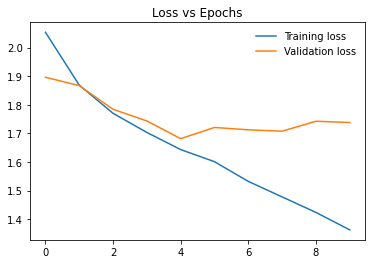

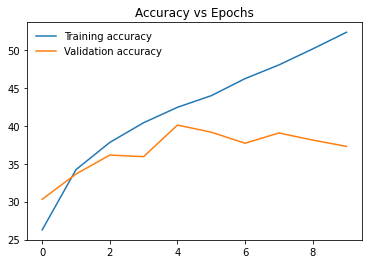

In [ ]:
convnet1 = ConvNet1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnet1.parameters())

BATCH_SIZE = 32
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

main(trainloader, validloader, convnet1, criterion, optimizer, device, epoch=10)

#### **5.4. Teste**

In [ ]:
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_acc, test_acc = predict(testloader, convnet1, criterion, device)

Test loss: 1.7521 -- Test accuracy: 37.08%


#### **5.5. Visualização das *feature maps* das camadas convolucionais**

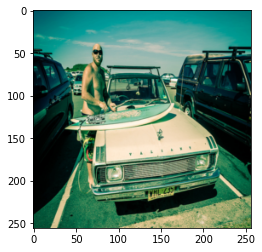

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
image, label = next(iter(trainloader))

plt.imshow(np.transpose(np.array(image.squeeze()), axes=(1, 2, 0)), cmap='gray');

In [ ]:
x = image
features_to_visualize = []

convnet1.eval()
with torch.no_grad():    
    for layer in convnet1.feature_extraction:
        x = layer(x.to(device))
        if isinstance(layer, nn.Conv2d):
            print(layer)
            features_to_visualize.append(x)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))


***Feature maps* da primeira camada convolucional** 

In [ ]:
(features_to_visualize[0].squeeze().shape)

torch.Size([64, 254, 254])

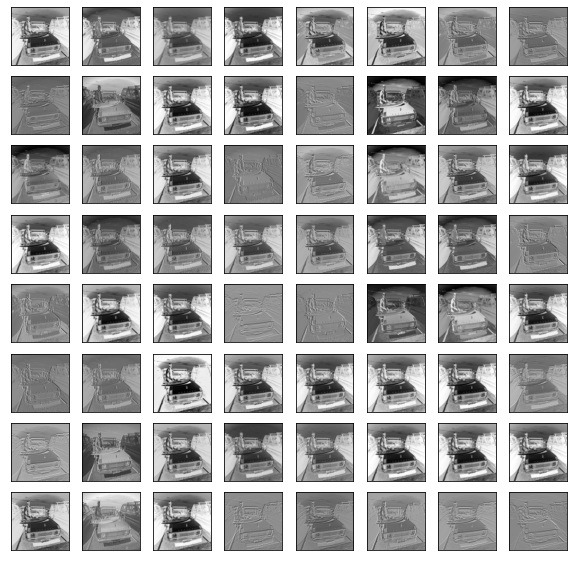

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(64):
    fig.add_subplot(8, 8, i+1)
    images = features_to_visualize[0].squeeze().cpu()
    plt.imshow(images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

***Feature maps* da segunda camada convolucional** 

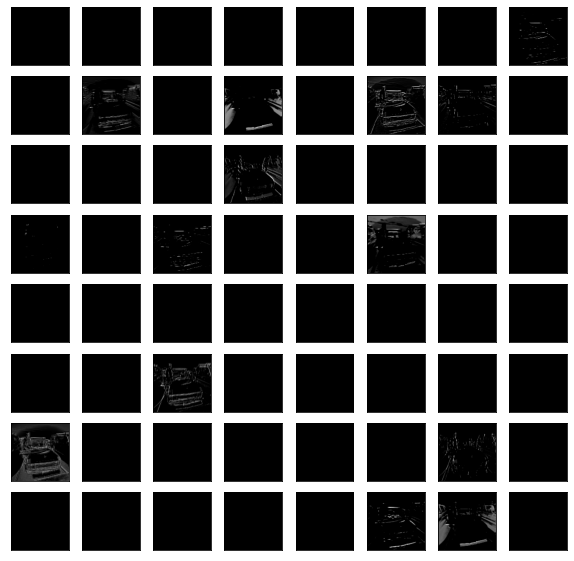

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(64):
    fig.add_subplot(8, 8, i+1)
    images = features_to_visualize[1].squeeze().cpu()
    plt.imshow(images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

***Feature maps* da terceira camada convolucional** 

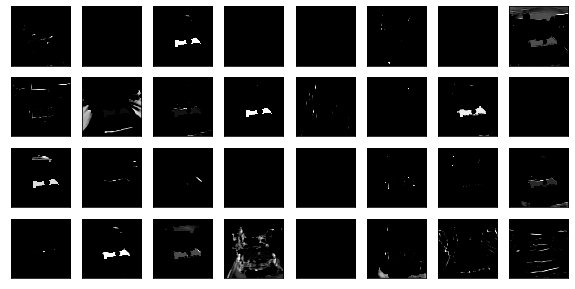

In [ ]:
fig = plt.figure(figsize=(10,5))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    images = features_to_visualize[2].squeeze().cpu()
    plt.imshow(images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

### **6. Rede convolucional II**

#### **6.1. Definição do modelo**

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        self.feature_extraction = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2)),
            ('relu1', nn.ReLU()),
            ('maxpool1', nn.MaxPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2)),
            ('relu2', nn.ReLU(0.5)),
            ('maxpool2', nn.MaxPool2d(kernel_size=2)),
            ('dropout2', nn.Dropout(0.5)),
            ('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1)),
            ('relu3', nn.ReLU(0.5)),
            ('maxpool3', nn.MaxPool2d(kernel_size=2)),
            ('dropout3', nn.Dropout(0.5))            
        ]))

        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(in_features=6*6*64, out_features=256)),
            ('relu4', nn.ReLU(0.5)),
            ('dropout4', nn.Dropout(0.5)),
            ('output', nn.Linear(in_features=256, out_features=10)),
        ]))


    def forward(self, x):
        x = self.feature_extraction(x)
        x = x.view(x.shape[0], -1)
        x = self.classification(x)
        return x

#### **6.2. Cálculo do número de parâmetros**

**Cálculo manual:**

In [ ]:
# Camada convolucional 1:
n_param_convlayer1 = 64*3*3*3 + 64 
# Camada convolucional 2:
n_param_convlayer2 = 64*3*3*64 + 64
# Camada convolucional 3:
n_param_convlayer3 = 32*3*3*64 + 32
# Camada linear 1:
n_param_linear = (30*30*32)*256 + 256
# Camada de saída:
n_param_output = 256*10 + 10

hands = [n_param_convlayer1, n_param_convlayer2, n_param_convlayer3, n_param_linear, n_param_output]
hands.append(np.sum(np.array(hands)))

for i, params in enumerate(hands):
    if i < len(hands)-2:
        print(f'Camada intermediária {i+1}: {params}')
    elif i == len(hands)-2:
        print(f'Camada de saída: {params}')
    else:
        print(f'Modelo completo: {params}')

Camada intermediária 1: 1792
Camada intermediária 2: 36928
Camada intermediária 3: 18464
Camada intermediária 4: 7373056
Camada de saída: 2570
Modelo completo: 7432810


**Cálculo a partir do modelo implementado**

In [ ]:
convnet = ConvNet2()
num_params = [params.numel() for params in list(convnet.parameters())] # Lista com o número de parâmetros de cada camada com bias e weights passados separadamente
num_params = list(np.array(num_params[::2]) + np.array(num_params[1::2])) # Lista com o número de parâmetros totais por camada
num_params.append(np.sum(np.array(num_params))) # Último elemento da lista tem o número total de parâmetros do modelo

for i, params in enumerate(num_params):
    if i < len(num_params)-2:
        print(f'Camada intermediária {i+1}: {params}')
    elif i == len(num_params)-2:
        print(f'Camada de saída: {params}')
    else:
        print(f'Modelo completo: {params}')

del convnet

Camada intermediária 1: 1568
Camada intermediária 2: 16416
Camada intermediária 3: 32832
Camada intermediária 4: 590080
Camada de saída: 2570
Modelo completo: 643466


#### **6.3. Treinamento**

Epoch: 1/10
Training loss: 2.1095 -- Training accuracy: 23.85% -- Validation loss: 1.9525 -- Validation accuracy: 29.48%
Epoch: 2/10
Training loss: 1.9311 -- Training accuracy: 31.52% -- Validation loss: 1.8237 -- Validation accuracy: 33.65%
Epoch: 3/10
Training loss: 1.8387 -- Training accuracy: 35.31% -- Validation loss: 1.7811 -- Validation accuracy: 34.79%
Epoch: 4/10
Training loss: 1.7927 -- Training accuracy: 36.62% -- Validation loss: 1.7525 -- Validation accuracy: 36.46%
Epoch: 5/10
Training loss: 1.7631 -- Training accuracy: 37.46% -- Validation loss: 1.7084 -- Validation accuracy: 38.23%
Epoch: 6/10
Training loss: 1.7366 -- Training accuracy: 38.39% -- Validation loss: 1.6746 -- Validation accuracy: 39.48%
Epoch: 7/10
Training loss: 1.7145 -- Training accuracy: 39.39% -- Validation loss: 1.6995 -- Validation accuracy: 39.38%
Epoch: 8/10
Training loss: 1.6930 -- Training accuracy: 40.60% -- Validation loss: 1.7244 -- Validation accuracy: 38.75%
Epoch: 9/10
Training loss: 1.679

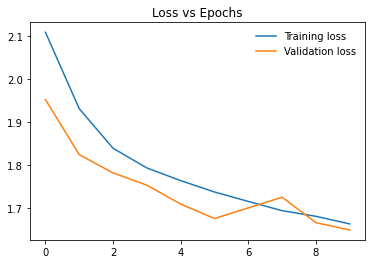

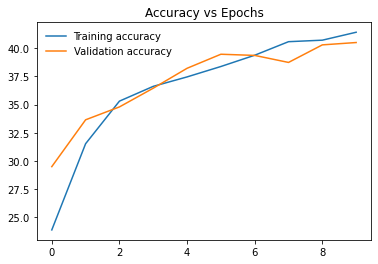

In [ ]:
convnet2 = ConvNet2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnet2.parameters())

BATCH_SIZE = 32
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

main(trainloader, validloader, convnet2, criterion, optimizer, device, epoch=10)

#### **6.4. Teste**

In [ ]:
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_acc, test_acc = predict(testloader, convnet2, criterion, device)

Test loss: 1.6843 -- Test accuracy: 39.17%


#### **6.5. Visualização das *feature maps* das camadas convolucionais**

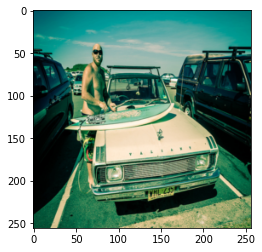

In [ ]:
plt.imshow(np.transpose(np.array(image.squeeze()), axes=(1, 2, 0)), cmap='gray');

In [ ]:
x = image
features_to_visualize = []

convnet2.eval()
with torch.no_grad():    
    for layer in convnet2.feature_extraction:
        x = layer(x.to(device))
        if isinstance(layer, nn.Conv2d):
            features_to_visualize.append(x)

***Feature maps* da primeira camada convolucional** 

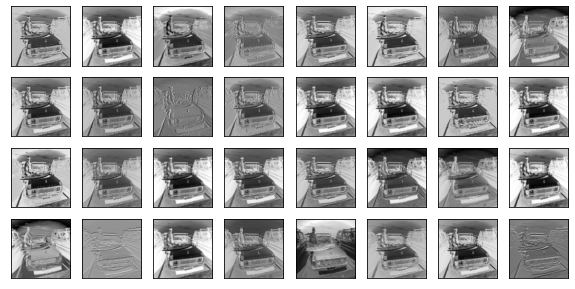

In [ ]:
fig = plt.figure(figsize=(10,5))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    images = features_to_visualize[0].squeeze().cpu()
    plt.imshow(images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

***Feature maps* da segunda camada convolucional** 

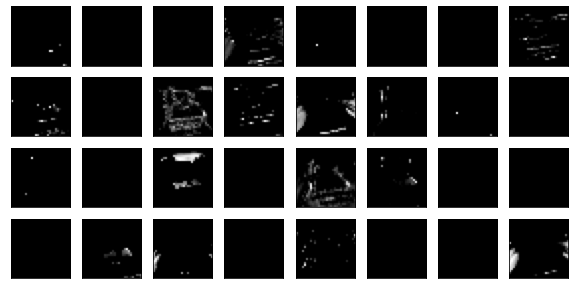

In [ ]:
fig = plt.figure(figsize=(10,5))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    images = features_to_visualize[1].squeeze().cpu()
    plt.imshow(images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

***Feature maps* da terceira camada convolucional** 

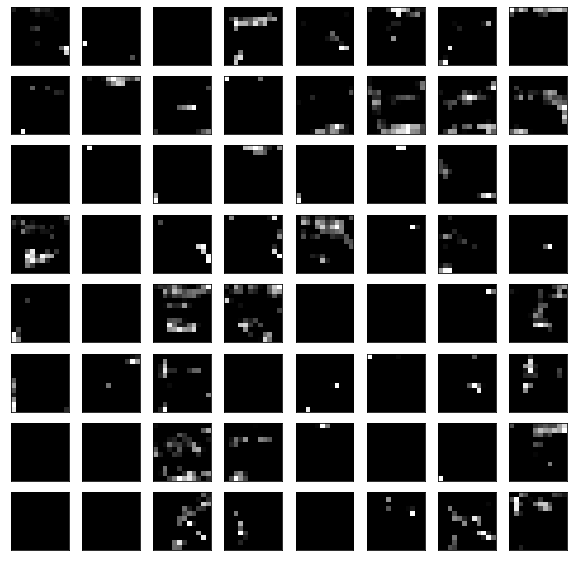

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(64):
    fig.add_subplot(8, 8, i+1)
    images = features_to_visualize[2].squeeze().cpu()
    plt.imshow(images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])